<a href="https://colab.research.google.com/github/NikkiShah93/food-classifier/blob/main/custom_data_CNN_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Custom Data CNN Model

In this project, we will be using our own custom data to train a convolutional neural network.

We will be extracting a subset of the [Food-101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) to be used as our input data.

The steps are as follows:
- Downloading the data
- Extracting a subset of samples



In [1]:
## first the imports
import os
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import transforms
from PIL import Image

In [2]:
## making the notebook device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
## setting the primary variables
DATA_PATH = '../data/'
DATA_PATH = Path(DATA_PATH)
DATA_PATH.mkdir(parents=True, exist_ok=True)

### Downloading the data

In [4]:
train_data = datasets.Food101(root = DATA_PATH,
                              split = 'train',
                              download=True,
                              )
test_data = datasets.Food101(root=DATA_PATH,
                             split = 'test',
                             download=True)
train_data

100%|██████████| 4996278331/4996278331 [02:54<00:00, 28558278.79it/s]


Extracting ../data/food-101.tar.gz to ../data


Dataset Food101
    Number of datapoints: 75750
    Root location: ../data
    split=train

We will be using `500` samples from these target labels:
`'samosa', 'macarons', 'hummus', 'guacamole', 'falafel', 'cannoli'`

In [5]:
FULL_PATH = DATA_PATH / 'food-101/images'
target_labels = ['samosa', 'macarons', 'hummus', 'guacamole', 'falafel', 'cannoli']
add_dict = {}
for dir, _, file in os.walk(FULL_PATH):
  if dir.split('/')[-1] in target_labels:
    print(dir, len(file))
    add_dict[dir] = random.sample(file, 500)

../data/food-101/images/guacamole 1000
../data/food-101/images/cannoli 1000
../data/food-101/images/hummus 1000
../data/food-101/images/falafel 1000
../data/food-101/images/samosa 1000
../data/food-101/images/macarons 1000


And moved them into a new directory that we will be using for our model.

In [6]:
## then just moving the files into a new location
NEW_PATH = DATA_PATH / 'smaple_data'
for key, vals in add_dict.items():
  train_label = 'train/'+key.split('/')[-1]
  test_label = 'test/'+key.split('/')[-1]
  CURRENT_PATH = FULL_PATH / key.split('/')[-1]
  TRAIN_FULL_NEW_PATH = NEW_PATH / train_label
  TEST_FULL_NEW_PATH = NEW_PATH / test_label
  # FULL_NEW_PATH.mkdir(parents=True, exist_ok=True)
  TRAIN_FULL_NEW_PATH.mkdir(parents=True, exist_ok=True)
  TEST_FULL_NEW_PATH.mkdir(parents=True, exist_ok=True)
  [os.rename(CURRENT_PATH / x, TRAIN_FULL_NEW_PATH / x) for x in vals[:int(len(vals)*.8)]]
  [os.rename(CURRENT_PATH / x, TEST_FULL_NEW_PATH / x) for x in vals[int(len(vals)*.8):]]

In [7]:
file_dict = {}
for dir, _, file in os.walk(NEW_PATH):
  if len(file)>0:
    file_dict[dir] = file
    print(dir, len(file))

../data/smaple_data/test/guacamole 100
../data/smaple_data/test/cannoli 100
../data/smaple_data/test/hummus 100
../data/smaple_data/test/falafel 100
../data/smaple_data/test/samosa 100
../data/smaple_data/test/macarons 100
../data/smaple_data/train/guacamole 400
../data/smaple_data/train/cannoli 400
../data/smaple_data/train/hummus 400
../data/smaple_data/train/falafel 400
../data/smaple_data/train/samosa 400
../data/smaple_data/train/macarons 400


 ### Composing a transform for our data

 This transform contains:
 - Image resizing - to ensure all the images are in the same shape
 - Horizantal flip - to introduce some complexity to the detection
 - Converting the `jpg` files to tensors


In [8]:
img_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.ToTensor()
])

Testing our transform on the randm images from the sample folder.

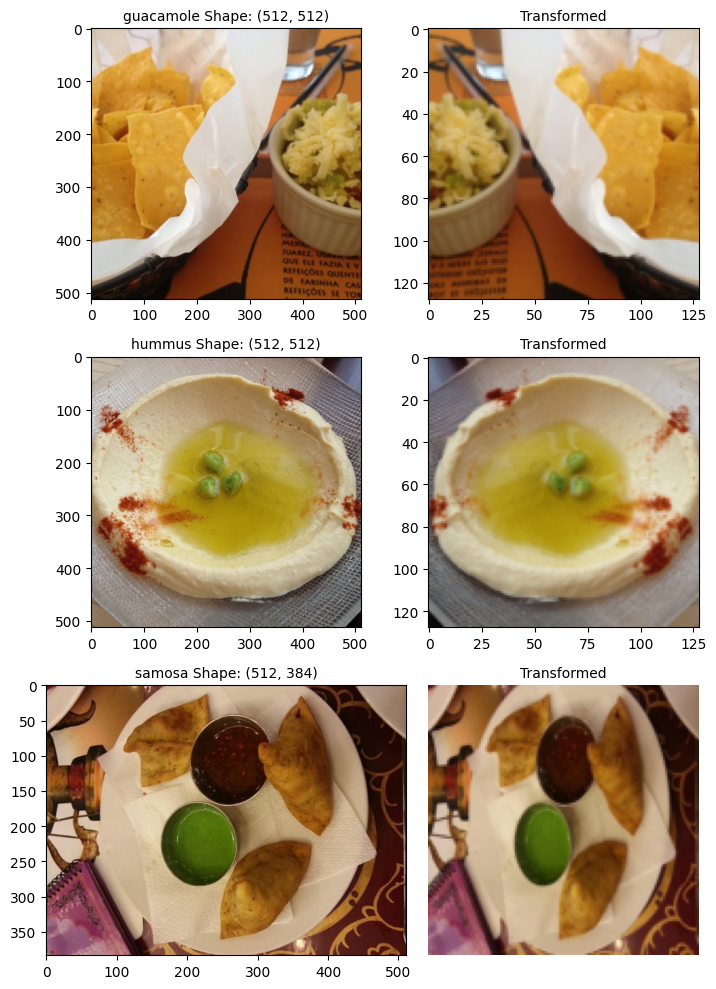

In [12]:
## loading some random pictures to visualize
n=0
fig, ax = plt.subplots(3, 2, figsize=(16, 10))
for k in file_dict:
  if np.random.randint(1000) % 2 and n < 3:
    index = np.random.randint(low=0, high = len(file_dict[k]))
    picked_image_path = f'{k}/{file_dict[k][index]}'
    ## opening the image by PIL
    # with Image.open(picked_image_path, 'r') as im:
    img = Image.open(picked_image_path, 'r')
    transformed_img = img_transform(img)
    # plt.subplot(3, 2, (n + 1, 1))
    ax[n, 0].imshow(img)
    ax[n, 0].set_title(f"{k.split('/')[-1]} Shape: {img.size}", fontsize=10)
    # plt.subplot(3, 2, (n + 1, 2))
    ax[n, 1].imshow(transformed_img.permute(1,2,0))
    ax[n, 1].set_title(f"Transformed", fontsize=10)
    n += 1
  plt.axis('off')
  plt.tight_layout();

### Loading the images

In [10]:
TRAINING_PATH = NEW_PATH / 'train'
TEST_PATH = NEW_PATH / 'test'
BATCH_SIZE = 16
train = datasets.ImageFolder(root=TRAINING_PATH,
                            transform=img_transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,shuffle=True)
test = datasets.ImageFolder(root=TEST_PATH,
                            transform=img_transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE)
class_names = train.classes
print('Classes in the data: ',class_names)
print('Dataset Shape: ', train)
print('Dataset Shape: ', test)

Classes in the data:  ['cannoli', 'falafel', 'guacamole', 'hummus', 'macarons', 'samosa']
Dataset Shape:  Dataset ImageFolder
    Number of datapoints: 2400
    Root location: ../data/smaple_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.3)
               ToTensor()
           )
Dataset Shape:  Dataset ImageFolder
    Number of datapoints: 600
    Root location: ../data/smaple_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.3)
               ToTensor()
           )


### Building the model

In [13]:
## we will be using the CNN from nn
class CNN(nn.Module):
  def __init__(self, n_channels, hidden_units, output_shape) -> None:
    super().__init__()
    self.loss_fn = nn.CrossEntropyLoss()
    self.cnn_block0 = nn.Sequential(
        nn.Conv2d(in_channels=n_channels, out_channels=hidden_units,
                  kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
          kernel_size=2),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )
    self.cnn_block1 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units//2,
                  kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units//2, out_channels=hidden_units//2,
          kernel_size=2),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )
    self.lin = nn.Sequential(
        nn.Flatten(1),
        nn.Linear((hidden_units//2)*30*30, hidden_units // 4 ),
        nn.ReLU(),
        nn.Linear(hidden_units // 4 , output_shape),
    )

  def forward(self, x, y):
    out = self.cnn_block0(x)
    out = self.cnn_block1(out)
    # print(out.shape)
    out = self.lin(out)
    loss = self.loss_fn(out, y)
    return out, loss

In [14]:
## creating an instance
model = CNN(n_channels=3,
            hidden_units=16,
            output_shape=len(class_names)).to(device)
# loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = torch.optim.Adam(params = model.parameters(),
                            lr = learning_rate)

In [15]:
## training loop
running_loss = 0
running_accuracy = 0
loss_dict = {}
epochs = 15
for e in range(epochs):
  for img, label in train_loader:
    img, label = img.to(device), label.to(device)
    # print(img.shape, label.shape)
    preds, loss = model(img, label)
    predlabels = torch.softmax(preds, 1).argmax()
    # loss = loss_fn(preds, label)
    running_loss += loss
    running_accuracy += (predlabels == label).sum()/len(label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if e %5==0:
    print(f'Epoch {e} running loss {running_loss/len(train_loader):.2f} running accuracy {(running_accuracy/len(train_loader))*100:.2f}%')
  running_accuracy = 0
  running_loss = 0

Epoch 0 running loss 1.81 running accuracy 11.58%
Epoch 5 running loss 1.79 running accuracy 16.54%
Epoch 10 running loss 1.79 running accuracy 15.54%


In [140]:
## evaluation loop
model.eval()
eval_running_loss = 0
eval_running_acc = 0
with torch.inference_mode():
  for img, label in test_loader:
    img, label = img.to(device), label.to(device)
    eval_preds, eval_loss = model(img, label)
    eval_label = torch.softmax(eval_preds, 1).argmax()
    # eval_loss = loss_fn(eval_preds, label)
    eval_running_loss += loss
    eval_running_acc += (eval_label == label).sum()/len(label)
print(f'Evaluation results: running loss {eval_running_loss/len(test_loader):.2f} | running accuracy {(eval_running_acc/len(test_loader))*100:.2f}%')

Evaluation results: running loss 1.80 | running accuracy 16.45%
